# Test Commands

In [34]:
import os
import torch
import torchaudio
import math, random
import librosa
from matplotlib import pyplot as plt
from torchaudio import transforms
from IPython.display import Audio

test_data = os.path.join('dataset', 'road_data', 'road54.wav')

metadata = torchaudio.info(test_data)
sig, sr = torchaudio.load(test_data)
sig.shape

torch.Size([2, 369939])

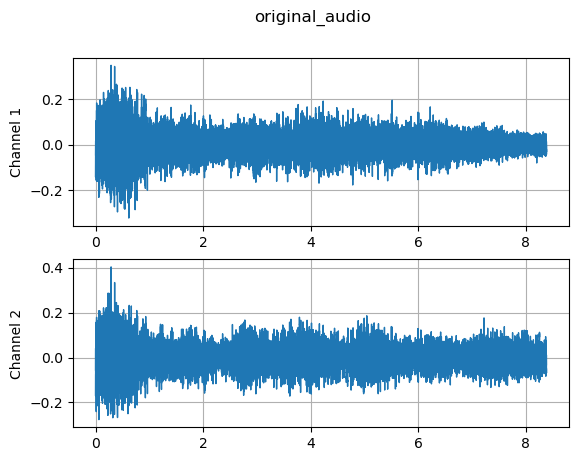

In [35]:
def plot_waveform(waveform, sample_rate, name):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(name)
    plt.show(block=False)
    
plot_waveform(sig, sr, "original_audio")

tensor([[ 11.9453,  18.0161,  20.2165,  ...,  21.2389,  12.0689,  24.7029],
        [ 20.7077,  18.9089,  25.5105,  ...,  24.7676,  11.7603,  27.0054],
        [ 19.0798,  15.0350,  26.8053,  ...,  23.8185,  11.7163,  24.6077],
        ...,
        [-44.1680, -49.3366, -49.3366,  ..., -49.3366, -49.3366, -49.3366],
        [-45.0792, -49.3366, -49.3366,  ..., -49.3366, -49.3366, -49.3366],
        [-44.8949, -49.3366, -49.3366,  ..., -49.3366, -49.3366, -49.3366]])


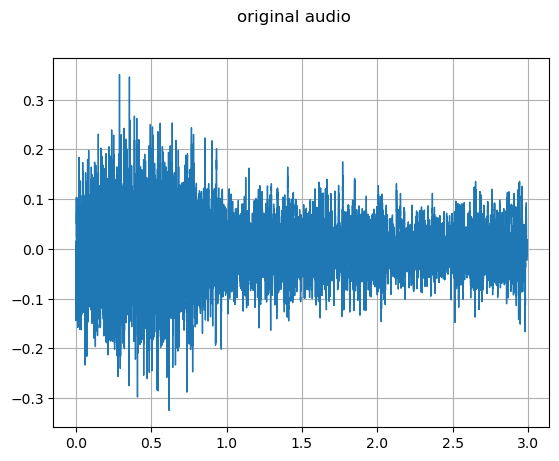

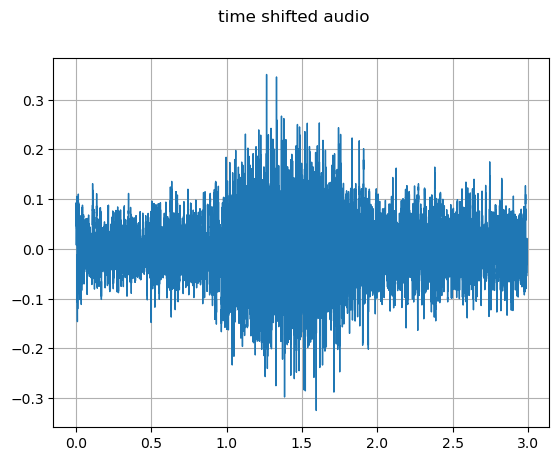

In [36]:
max_ms = 3000
new_sr = 44100
shift_pct = 0.4
n_mels=64
n_fft=1024
hop_len=None
top_db = 80

if sig.shape[0] != 1:
    resig = sig[:1, :]
    
if (sr != new_sr):
    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, new_sr)(resig)
    
num_rows, sig_len = resig.shape
max_len = sr//1000 * max_ms

if (sig_len > max_len):
      # Truncate the signal to the given length
    sig = resig[:,:max_len]

elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
    pad_begin_len = random.randint(0, max_len - sig_len)
    pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
    pad_begin = torch.zeros((num_rows, pad_begin_len))
    pad_end = torch.zeros((num_rows, pad_end_len))

    sig = torch.cat((pad_begin, resig, pad_end), 1)

_, sig_len = sig.shape
shift_amt = int(random.random() * shift_pct * sig_len)
shifted_sig = sig.roll(shift_amt)

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
spec = transforms.MelSpectrogram(new_sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)


    # Convert to decibels
spec = transforms.AmplitudeToDB(top_db=top_db)(spec)

#spec = torch.abs(spec)

print(spec[0])
plot_waveform(sig,new_sr,'original audio')
plot_waveform(shifted_sig,new_sr, 'time shifted audio')

In [37]:
Audio(sig.numpy(), rate=new_sr)

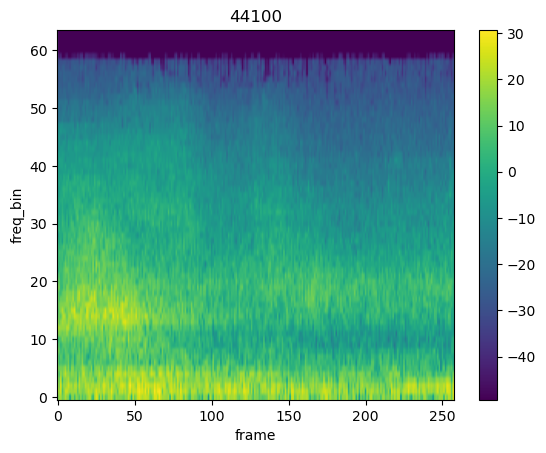

In [38]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)
    
plot_spectrogram(spec[0], new_sr)

In [ ]:
filename = 'sound_classification_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [9]:
external_model = pickle.load(open('sound_classification_model.sav', 'rb'))

In [85]:
# ----------------------------
def inference (model, data):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
      # Get the input features and target labels, and put them on the GPU
      data_1 = data[0].clone().detach()
      data_2 = torch.Tensor(data[1])
      inputs = data_1.to(device)
      label = data_2.to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.float().mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s
      print(inputs)
      # Get predictions
      model.to(device)
      outputs = model(inputs.unsqueeze(0))

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
    
  #acc = correct_prediction/total_prediction
  print(prediction)

# Run inference on trained model with the validation set
inference(external_model, processed_audio)

tensor([[[ 0.2320,  0.6700,  0.2891,  ...,  0.0316,  0.4621,  0.5305],
         [-0.5503,  0.1242,  0.3748,  ...,  0.3358,  0.1445,  0.4761],
         [-0.3932,  0.4798,  0.3261,  ..., -0.1323,  0.0590, -0.1956],
         ...,
         [-0.5741, -0.5741, -0.5741,  ..., -0.5741, -0.5741, -0.5741],
         [-0.5741, -0.5741, -0.5741,  ..., -0.5741, -0.5741, -0.5741],
         [-0.5741, -0.5741, -0.5741,  ..., -0.5741, -0.5741, -0.5741]],

        [[ 0.5425,  0.6041,  0.4553,  ..., -0.5061,  0.5165,  0.3901],
         [ 0.1324,  0.2135,  0.5705,  ..., -0.1682,  0.1633,  0.4532],
         [-0.5741,  0.6044,  0.3165,  ..., -0.3917,  0.3423, -0.1641],
         ...,
         [-0.5741, -0.5741, -0.5741,  ..., -0.5741, -0.5741, -0.5741],
         [-0.5741, -0.5741, -0.5741,  ..., -0.5741, -0.5741, -0.5741],
         [-0.5741, -0.5741, -0.5741,  ..., -0.5741, -0.5741, -0.5741]]],
       device='cuda:0')
tensor([2], device='cuda:0')


# Manipulate LSAFEV dataset

In [9]:
import pandas as pd

ambulance = pd.read_csv('D://Thesis//Emergency Priority//sound-recognition//dataset//Ambulance_final.csv')
ambulance['file_path'] = '//ambulance_data'
ambulance['classID'] = "1"
ambulance.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc15,mfcc15.1,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,file_path,classID
0,ambulance142.wav,0.345168,0.308853,1287.145377,1261.699532,2379.211895,0.081083,-74.003632,163.974854,-72.760811,...,-2.421668,-2.059879,9.900706,6.835095,2.545403,-4.973841,4.305125,Ambulance,//ambulance_data,1
1,ambulance449.wav,0.386696,0.263407,2223.479605,2115.848084,4718.463135,0.122690,10.772755,101.783501,-41.391842,...,-5.581450,-8.168453,1.215980,-9.383577,1.723579,0.454906,9.782359,Ambulance,//ambulance_data,1
2,ambulance888.wav,0.517708,0.281876,1393.990435,1586.770873,2898.286321,0.064444,-52.157757,144.876480,-45.382484,...,7.127768,2.115508,1.014645,-0.404026,3.214492,-5.129189,0.641621,Ambulance,//ambulance_data,1
3,ambulance474.wav,0.229988,0.184972,2211.761868,1923.778124,3913.245568,0.116267,-130.663757,88.106293,-45.787319,...,24.814060,10.781730,-1.599966,-20.135389,-10.052261,-3.237577,11.093946,Ambulance,//ambulance_data,1
4,ambulance305.wav,0.149670,0.115018,1266.959915,1654.095586,1831.978666,0.094191,-213.125717,138.419174,-6.672751,...,9.291833,4.321001,5.267659,-1.062411,-0.764217,-4.817847,0.678133,Ambulance,//ambulance_data,1


In [10]:
road = pd.read_csv('D://Thesis//Emergency Priority//sound-recognition//dataset//Road_final.csv')
road['file_path'] = '//road_data'
road['classID'] = "0"
road.head()

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc15,mfcc15.1,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,file_path,classID
0,road324.wav,0.442203,0.022001,2545.346793,2426.479510,4754.282790,0.155189,-270.384613,100.619019,-10.223790,...,18.793995,-5.305555,-0.965415,5.482495,-10.139045,-2.003446,3.736357,Road,//road_data,0
1,road508.wav,0.337758,0.206505,3470.430019,2706.420324,6899.114051,0.181979,11.297463,41.953815,-35.142498,...,-0.847138,-7.962325,-2.489496,-5.065870,15.039159,-7.175189,2.037403,Road,//road_data,0
2,road351.wav,0.440022,0.173755,1248.230706,1904.995271,2556.032621,0.020921,-134.684311,138.695663,-9.734646,...,9.100524,3.403701,8.452733,1.088790,4.929297,-0.253739,4.125893,Road,//road_data,0
3,road703.wav,0.600494,0.040601,1075.899022,1827.481394,1814.793513,0.032874,-252.906036,157.615418,9.920370,...,1.136444,-3.741317,3.954798,-0.935155,8.923501,3.227440,6.275182,Road,//road_data,0
4,road681.wav,0.631075,0.065356,742.548260,1372.708521,1231.119479,0.023869,-257.946930,187.372162,7.777202,...,7.443036,-0.647730,2.444229,-2.062293,6.974404,1.464423,2.268083,Road,//road_data,0


In [11]:
merge_data = pd.concat([ambulance, road])
merge_data

,filename,chroma_stft,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc15,mfcc15.1,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label,file_path,classID
0,ambulance142.wav,0.345168,0.308853,1287.145377,1261.699532,2379.211895,0.081083,-74.003632,163.974854,-72.760811,...,-2.421668,-2.059879,9.900706,6.835095,2.545403,-4.973841,4.305125,Ambulance,//ambulance_data,1
1,ambulance449.wav,0.386696,0.263407,2223.479605,2115.848084,4718.463135,0.122690,10.772755,101.783501,-41.391842,...,-5.581450,-8.168453,1.215980,-9.383577,1.723579,0.454906,9.782359,Ambulance,//ambulance_data,1
2,ambulance888.wav,0.517708,0.281876,1393.990435,1586.770873,2898.286321,0.064444,-52.157757,144.876480,-45.382484,...,7.127768,2.115508,1.014645,-0.404026,3.214492,-5.129189,0.641621,Ambulance,//ambulance_data,1
3,ambulance474.wav,0.229988,0.184972,2211.761868,1923.778124,3913.245568,0.116267,-130.663757,88.106293,-45.787319,...,24.814060,10.781730,-1.599966,-20.135389,-10.052261,-3.237577,11.093946,Ambulance,//ambulance_data,1
4,ambulance305.wav,0.149670,0.115018,1266.959915,1654.095586,1831.978666,0.094191,-213.125717,138.419174,-6.672751,...,9.291833,4.321001,5.267659,-1.062411,-0.764217,-4.817847,0.678133,Ambulance,//ambulance_data,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,road638.wav,0.620770,0.031281,931.578184,1753.522574,1576.478929,0.023625,-311.354034,158.753723,12.853130,...,1.119874,-6.147216,3.674873,-2.406534,3.062174,0.890442,5.863816,Road,//road_data,0
898,road323.wav,0.486262,0.086026,2809.751806,2664.180170,5862.207501,0.153611,-60.523140,79.998100,-21.354570,...,7.150903,1.223076,4.254593,-0.084353,0.660076,-2.794935,-0.689680,Road,//road_data,0
899,road233.wav,0.722937,0.066561,1218.645216,1738.932865,2446.503155,0.029353,-203.562195,148.460327,-20.818197,...,7.533079,1.822413,5.510491,0.000635,3.786338,1.777025,5.937325,Road,//road_data,0
900,road244.wav,0.672640,0.179680,1734.890060,1980.674638,3202.235765,0.078792,-34.751610,124.614510,-38.273533,...,10.895624,1.861239,9.542007,4.217642,7.684665,1.724497,7.023211,Road,//road_data,0


In [12]:
merge_data.to_csv('D://Thesis//Emergency Priority//dataset//audio_dataset.csv', index=False)

# Import final dataset

In [4]:
import pandas as pd

# Read metadata file
metadata_file = 'D://Thesis//Emergency Priority//dataset//audio_dataset.csv'
df = pd.read_csv(metadata_file)
df.head()

# Take relevant columns
df = df[['filename', 'file_path', 'classID']]
df

,filename,file_path,classID
0,ambulance142.wav,//ambulance_data,1
1,ambulance449.wav,//ambulance_data,1
2,ambulance888.wav,//ambulance_data,1
3,ambulance474.wav,//ambulance_data,1
4,ambulance305.wav,//ambulance_data,1
...,...,...,...
1829,road638.wav,//road_data,0
1830,road323.wav,//road_data,0
1831,road233.wav,//road_data,0
1832,road244.wav,//road_data,0


# Create Audio Manipulation

In [1]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))


  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)


  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

# Create Dataset loader

In [2]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class AudioDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 3000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx,'file_path'] + '//' + self.df.loc[idx,'filename']
    #self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [5]:
from torch.utils.data import random_split

data_path = 'D://Thesis//Emergency Priority//sound-recognition//dataset'
data_set = AudioDS(df, data_path)


# Random split of 80:20 between training and validation
num_items = len(data_set)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(data_set, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

# Create Model

In [7]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
model = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Check that it is on Cuda
next(model.parameters()).device

device(type='cuda', index=0)

# Train Model

In [70]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')
    
  print("--------------------- Training Start ----------------------")
  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        model = model.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        if i % 10 == 0:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')
  
num_epochs=6
training(model, train_dl, num_epochs)

--------------------- Training Start ----------------------
[1,     1] loss: 0.239
[1,    11] loss: 2.573
[1,    21] loss: 4.868
[1,    31] loss: 7.145
[1,    41] loss: 9.379
[1,    51] loss: 11.489
[1,    61] loss: 13.554
[1,    71] loss: 15.438
[1,    81] loss: 17.220
[1,    91] loss: 18.731
Epoch: 0, Loss: 2.05, Accuracy: 0.45
[2,     1] loss: 0.161
[2,    11] loss: 1.616
[2,    21] loss: 2.913
[2,    31] loss: 3.933
[2,    41] loss: 4.863
[2,    51] loss: 5.808
[2,    61] loss: 6.736
[2,    71] loss: 7.383
[2,    81] loss: 7.941
[2,    91] loss: 8.429
Epoch: 1, Loss: 0.92, Accuracy: 0.86
[3,     1] loss: 0.088
[3,    11] loss: 0.702
[3,    21] loss: 1.079
[3,    31] loss: 1.540
[3,    41] loss: 2.012
[3,    51] loss: 2.317
[3,    61] loss: 2.783
[3,    71] loss: 3.049
[3,    81] loss: 3.361
[3,    91] loss: 3.699
Epoch: 2, Loss: 0.40, Accuracy: 0.92
[4,     1] loss: 0.065
[4,    11] loss: 0.384
[4,    21] loss: 0.707
[4,    31] loss: 1.027
[4,    41] loss: 1.550
[4,    51] loss: 1.

In [71]:
torch.save(model.state_dict(), 'siren_detection_model.pth')

In [8]:
trained_model = AudioClassifier()
trained_model.load_state_dict(torch.load('siren_detection_model.pth'))
trained_model = trained_model.to(device)

# Inference

In [39]:
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s
      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
    
      for i in prediction:
            if i == 1:
                print('Ambulance Detected')
            else:
                print('No Ambulance')
      #print('Predicted:', prediction)
      #print('Actual:', labels)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(trained_model, val_dl)

No Ambulance
No Ambulance
No Ambulance
No Ambulance
No Ambulance
No Ambulance
Ambulance Detected
Ambulance Detected
Ambulance Detected
No Ambulance
Ambulance Detected
No Ambulance
No Ambulance
Ambulance Detected
No Ambulance
Ambulance Detected
No Ambulance
No Ambulance
No Ambulance
Ambulance Detected
Ambulance Detected
No Ambulance
No Ambulance
Ambulance Detected
Ambulance Detected
Ambulance Detected
Ambulance Detected
No Ambulance
Ambulance Detected
No Ambulance
Ambulance Detected
No Ambulance
Ambulance Detected
No Ambulance
No Ambulance
No Ambulance
Ambulance Detected
No Ambulance
Ambulance Detected
Ambulance Detected
Ambulance Detected
No Ambulance
No Ambulance
Ambulance Detected
Ambulance Detected
Ambulance Detected
No Ambulance
Ambulance Detected
No Ambulance
Ambulance Detected
Ambulance Detected
No Ambulance
No Ambulance
No Ambulance
Ambulance Detected
Ambulance Detected
Ambulance Detected
Ambulance Detected
Ambulance Detected
No Ambulance
No Ambulance
No Ambulance
Ambulance Dete

# Feed Single Data

In [231]:
import torchaudio
from IPython.display import Audio

data_path = 'D://Thesis//Emergency Priority//dataset//road_data//road34.wav'
sig, sr = torchaudio.load(data_path)

Audio(sig.numpy()[0], rate=sr)

def process_audio(audio):
    
    duration = 4000
    sr = 44100
    channel = 2
    shift_pct = 0.4
    class_id = 0 #siren is 7
    
    #audio_file = self.data_path + self.df.loc[idx,'file_path'] + '//' + self.df.loc[idx,'filename']
    #self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    #class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio)
    
    reaud = AudioUtil.resample(aud, sr)
    rechan = AudioUtil.rechannel(reaud, channel)

    #dur_aud = AudioUtil.pad_trunc(rechan, duration)
    shift_aud = AudioUtil.time_shift(rechan, shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

processed_audio = process_audio(data_path)
print(processed_audio)

(tensor([[[ 27.3107,  26.5599,  27.9763,  ...,  16.6296,  20.8776,  22.9111],
         [ 21.3255,  26.8543,  26.9987,  ...,  17.7892,  21.2407,  20.1065],
         [ 11.5656,  22.1966,  21.3494,  ...,  13.9362,  14.4440,  13.6754],
         ...,
         [-32.9196, -39.4222, -39.4222,  ..., -39.4222, -39.4222, -39.4222],
         [-32.8102, -39.4222, -39.4222,  ..., -39.4222, -39.4222, -39.4222],
         [-32.6616, -39.4222, -39.4222,  ..., -39.4222, -39.4222, -39.4222]],

        [[ 26.3468,  24.9435,  26.2747,  ...,  18.3665,  22.9581,  24.6786],
         [ 20.6083,  24.2898,  25.0454,  ...,  20.5707,  24.0757,  21.1878],
         [ 12.6996,  18.0171,  18.0091,  ...,  18.6834,  19.7146,  18.8760],
         ...,
         [-31.2711, -39.4222, -39.4222,  ..., -39.4222, -39.4222, -39.4222],
         [-31.3844, -39.4222, -39.4222,  ..., -39.4222, -39.4222, -39.4222],
         [-31.2421, -39.4222, -39.4222,  ..., -39.4222, -39.4222, -39.4222]]]), 0)


In [210]:
df.loc[987, 'classID']

0

In [234]:
# ----------------------------
def inference (model, data):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
      # Get the input features and target labels, and put them on the GPU
      data_1 = data[0].clone().detach()
      data_2 = torch.Tensor(data[1])
      inputs = data_1.to(device)
      label = data_2.to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.float().mean(), inputs.std()
      input = (inputs - inputs_m) / inputs_s
      print(data_2)
      # Get predictions
      model.to(device)
      outputs = model(inputs.unsqueeze(0))

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      correct_prediction += (prediction == label).sum().item()
      total_prediction += prediction.shape[0]
      print(prediction)
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(model, processed_audio)

tensor([])
tensor([1], device='cuda:0')
Accuracy: 0.00, Total items: 1


In [154]:
audio_file = data_path + df.loc[5, 'file_path'] + '//' + df.loc[5,'filename']
print(audio_file)

D://Thesis//Emergency Priority//dataset//ambulance_data//ambulance204.wav
